This notebook investigates the possibility of doing hypothesis testing on a lognormal distribution.
Inverting a lognormal distribution is possible if the population variance is known, which is often unknown in practical statistical applications.
This notebook demonstrates high accuracy for using the sample variance as estimator of the population variance:
- accuracy averages above 95% across all sample sizes.
- accuracy stabilizes consistently above 95% as sample size exceeds 2000.
- bias reduction through bootstrapping seems to be effective in improving accuracy, however its beneficial effects decrease as sample size enlarges.

In [2]:
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

In [3]:
def pull_observations_from_lognormal(sample_size: int):
    """
    Generates a sample from a standard lognormal distribution.

    Args:
        sample_size: The number of observations in the sample.

    Returns:
        A NumPy array containing the generated sample.
    """
    return rng.lognormal(mean=0.0, sigma=1.0, size=sample_size)


def calculate_confidence_interval(data: pd.Series, alpha: float):
    """
    Calculates the confidence interval for the mean of a sample.

    Args:
        data: A pandas Series containing the sample data.
        alpha: The significance level (e.g., 0.05 for a 95% confidence interval).

    Returns:
        A tuple containing the upper and lower bounds of the confidence interval.
    """
    sample_mean = data.mean()
    sample_std_dev = data.std()
    sample_size = len(data)
    std_error = sample_std_dev / np.sqrt(sample_size)

    upper_bound = scipy.stats.norm.ppf(1 - alpha, sample_mean, std_error)
    lower_bound = scipy.stats.norm.ppf(alpha, sample_mean, std_error)
    return upper_bound, lower_bound


def bootstrap_std_dev(series, n_bootstraps=10000):
    """
    Calculates the bootstrap estimate of the standard deviation of a sample.

    Args:
        series: The pandas Series containing the sample data.
        n_bootstraps: The number of bootstrap replicates to generate.
    
    Returns:
        The bootstrap estimate of the standard deviation.
    """
    series = pd.Series(series)
    bootstrap_std_devs = []
    for _ in range(n_bootstraps):
        bootstrap_sample = series.sample(n=len(series), replace=True)
        bootstrap_std_devs.append(bootstrap_sample.std())

    return np.mean(bootstrap_std_devs)


def invert_confidence_intervals(upper_bound: float, lower_bound: float, sample_std_dev: float, pop_std_dev: float):
    """
    Transforms confidence intervals from the log-space to the original space.

    Args:
        upper_bound: Upper bound of the confidence interval in log-space.
        lower_bound: Lower bound of the confidence interval in log-space.
        sample_std_dev: Sample standard deviation in log-space.
        pop_std_dev: Population standard deviation in log-space.

    Returns:
        Tuples containing the transformed upper and lower bounds 
        for the sample and population distributions.
    """
    sample_upper_bound = np.exp(upper_bound + sample_std_dev ** 2 / 2)
    sample_lower_bound = np.exp(lower_bound + sample_std_dev ** 2 / 2)

    pop_upper_bound = np.exp(upper_bound + pop_std_dev ** 2 / 2)
    pop_lower_bound = np.exp(lower_bound + pop_std_dev ** 2 / 2)

    return sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound


def test_confidence_interval(test_instances: int, sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound):
    """
    Tests if randomly generated observations fall within the specified confidence intervals of the population and sample.

    Args:
        test_instances: Number of test observations to generate.
        sample_upper_bound: Upper bound of the sample's confidence interval (CI).
        sample_lower_bound: Lower bound of the sample's confidence interval.
        pop_upper_bound: Upper bound of the population's confidence interval.
        pop_lower_bound: Lower bound of the population's confidence interval.

    Returns:
        A list of strings representing the classification of each test observation:
            'TP': True Positive (Test instance is inside both the populatin and the sample transformed CI)
            'FP': False Positive (Test instance is outside the population transformed CI, but inside the sample's)
            'TN': True Negative (Test instance is outside both the populatin and the sample transformed CI)
            'FN': False Negative (Test instance is inside the population transformed CI, but outside the sample's)
    """
    testing_instances = pull_observations_from_lognormal(sample_size=test_instances)

    sample_check = ''
    pop_check = ''
    result = []

    for sample in testing_instances:
        if sample_upper_bound > sample and sample_lower_bound < sample: 
            sample_check = 'inside'
        elif sample_lower_bound > sample: 
            sample_check = 'observation_below_lower'
        else: 'observation_above_upper'

        if pop_upper_bound > sample and pop_lower_bound < sample: 
            pop_check = 'inside'
        elif pop_lower_bound > sample: 
            pop_check = 'observation_below_lower'
        else: 'observation_above_upper'

        if sample_check == 'inside' and pop_check == 'inside':
            result.append('TP')
        elif sample_check == 'inside' and pop_check != 'inside':
            result.append('FP')
        elif sample_check != 'inside' and pop_check != 'inside':
            result.append('TN')
        elif sample_check != 'inside' and pop_check == 'inside':
            result.append('FN')

    return result


def calculate_confusion_matrix(list_of_results):
    """
    Calculates the confusion matrix from a list of classification results.

    Args:
        list_of_results: A list of strings representing the classification results.

    Returns:
        A tuple containing the number of True Positives (TP), False Positives (FP), 
        True Negatives (TN), and False Negatives (FN).
    """

    tp = sum(result == 'TP' for result in list_of_results)
    fp = sum(result == 'FP' for result in list_of_results)
    tn = sum(result == 'TN' for result in list_of_results)
    fn = sum(result == 'FN' for result in list_of_results)
    
    print(f"TPs are {tp}, FPs are {fp}, TNs are {tn}, FNs are {fn}")
    return tp, fp, tn, fn


def add_observation_to_df(df, sample_size, is_bootstrapped, tp, fp, tn, fn):
    """
    Adds a new row to a DataFrame with the specified results.

    Args:
        df: The existing DataFrame.
        sample_size: The sample size for the current iteration.
        is_bootstrapped: Boolean indicating whether bootstrapping was used.
        tp: Number of True Positives.
        fp: Number of False Positives.
        tn: Number of True Negatives.
        fn: Number of False Negatives.

    Returns:
        The updated DataFrame.
    """

    new_row = pd.DataFrame({
        'sample_size': [sample_size],
        'is_bootstrapped': [is_bootstrapped],
        'true_positives': [tp],
        'false_positives': [fp],
        'true_negatives': [tn],
        'false_negatives': [fn]
    })

    if df.empty:
        return new_row
    else:
        return pd.concat([df, new_row], ignore_index=True)


def iterate_testing(start_sample_size = 10, end_sample_size = 100000, increase_in_sample_size = 10, boostrap_sample_st_dev = False, bootstrap_iterations = 1000):
    """
    Iterates through different sample sizes, performs the confidence interval testing and stores its result.

    Args:
        start_sample_size: The starting sample size.
        end_sample_size: The ending sample size.
        increase_in_sample_size: The increment in sample size for each iteration.
        boostrap_sample_st_dev: Boolean indicating whether to use bootstrapped standard deviation.
        bootstrap_iterations: Number of bootstrap iterations if bootstrapping is used.

    Returns:
        A DataFrame containing the results for each sample size.
    """

    df = pd.DataFrame()
    for i in range(start_sample_size, end_sample_size, increase_in_sample_size):
        sample = pull_observations_from_lognormal(i)
        log_sample = np.log(sample)
        up, low = calculate_confidence_interval(log_sample, 0.05)

        if boostrap_sample_st_dev:
            st_dev_estimator = bootstrap_std_dev(log_sample, n_bootstraps=bootstrap_iterations)
        else:
            st_dev_estimator = log_sample.std()
        
        sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound = invert_confidence_intervals(up, low, st_dev_estimator, 1)
        
        test_result = test_confidence_interval(1000000, sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound)

        tp, fp, tn, fn = calculate_confusion_matrix(test_result)
        df = add_observation_to_df(df, i, boostrap_sample_st_dev, tp, fp, tn, fn)
        print(f"The sample size was {i}, with bias correction boostrapping set to {boostrap_sample_st_dev}")
    return df

def iterate_testing_embbedded_ab_boostrapping(start_sample_size = 10, end_sample_size = 100000, increase_in_sample_size = 10, bootstrap_iterations = 2000):
    """
    Iterates through different sample sizes, performs the inversion of the confidence interval testing, with and without boostrapping for bias reduction, and stores its result.

    Args:
        start_sample_size: The starting sample size.
        end_sample_size: The ending sample size.
        increase_in_sample_size: The increment in sample size for each iteration.
        bootstrap_iterations: Number of bootstrap iterations.

    Returns:
        A DataFrame containing the results for each sample size.
    """

    df = pd.DataFrame()
    for i in range(start_sample_size, end_sample_size, increase_in_sample_size):
        sample = pull_observations_from_lognormal(i)
        log_sample = np.log(sample)
        up, low = calculate_confidence_interval(log_sample, 0.05)

        st_dev_estimator_b = bootstrap_std_dev(log_sample, n_bootstraps=bootstrap_iterations)
        st_dev_estimator = log_sample.std()
        
        sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound = invert_confidence_intervals(up, low, st_dev_estimator, 1)
        sample_upper_bound_b, sample_lower_bound_b, pop_upper_bound_b, pop_lower_bound_b = invert_confidence_intervals(up, low, st_dev_estimator_b, 1)
        
        test_result = test_confidence_interval(1000000, sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound)
        test_result_b = test_confidence_interval(1000000, sample_upper_bound_b, sample_lower_bound_b, pop_upper_bound_b, pop_lower_bound_b)

        tp, fp, tn, fn = calculate_confusion_matrix(test_result)
        tp_b, fp_b, tn_b, fn_b = calculate_confusion_matrix(test_result_b)
        df = add_observation_to_df(df, i, False, tp, fp, tn, fn)
        df = add_observation_to_df(df, i, True, tp_b, fp_b, tn_b, fn_b)
        print(f"The sample size was {i}")
    return df 

In [4]:
non_boostrapped_df = iterate_testing(start_sample_size=10, end_sample_size=10000, increase_in_sample_size=10)
boostrapped_df = iterate_testing(start_sample_size=10, end_sample_size=10000, increase_in_sample_size=10, boostrap_sample_st_dev=True)

df = pd.concat([non_boostrapped_df, boostrapped_df], ignore_index=True)

df['accuracy'] = (df['true_positives'] + df['true_negatives']) / (df['true_positives'] + df['false_positives'] + df['true_negatives'] + df['false_negatives']) * 100
df['recall'] = (df['true_positives']) / (df['true_positives'] + df['false_negatives']) * 100
df['precision'] = (df['true_positives'] ) / (df['true_positives'] + df['false_positives']) * 100

df

TPs are 452703, FPs are 55378, TNs are 467539, FNs are 24380
The sample size was 10, with bias correction boostrapping set to False
TPs are 253757, FPs are 5107, TNs are 738891, FNs are 2245
The sample size was 20, with bias correction boostrapping set to False
TPs are 97089, FPs are 161558, TNs are 631161, FNs are 110192
The sample size was 30, with bias correction boostrapping set to False
TPs are 154384, FPs are 63239, TNs are 742977, FNs are 39400
The sample size was 40, with bias correction boostrapping set to False
TPs are 190662, FPs are 671, TNs are 807566, FNs are 1101
The sample size was 50, with bias correction boostrapping set to False
TPs are 178696, FPs are 3289, TNs are 815903, FNs are 2112
The sample size was 60, with bias correction boostrapping set to False
TPs are 199114, FPs are 25452, TNs are 757433, FNs are 18001
The sample size was 70, with bias correction boostrapping set to False
TPs are 118784, FPs are 22511, TNs are 823012, FNs are 35693
The sample size was 8

,sample_size,is_bootstrapped,true_positives,false_positives,true_negatives,false_negatives,accuracy,recall,precision
0,10,False,452703,55378,467539,24380,92.0242,94.889778,89.100557
1,20,False,253757,5107,738891,2245,99.2648,99.123054,98.027149
2,30,False,97089,161558,631161,110192,72.8250,46.839315,37.537261
3,40,False,154384,63239,742977,39400,89.7361,79.668084,70.941031
4,50,False,190662,671,807566,1101,99.8228,99.425854,99.649303
...,...,...,...,...,...,...,...,...,...
1993,9950,True,16257,738,982276,729,99.8533,95.708230,95.657546
1994,9960,True,16395,250,983110,245,99.9505,98.527644,98.498047
1995,9970,True,14935,1314,982387,1364,99.7322,91.631388,91.913349
1996,9980,True,12026,4399,978952,4623,99.0978,72.232567,73.217656


<Axes: xlabel='sample_size', ylabel='accuracy'>

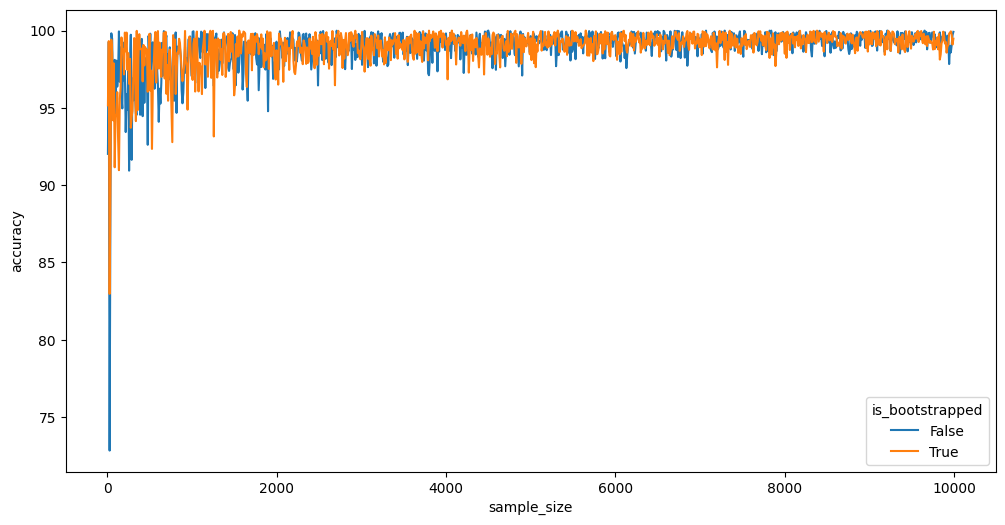

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='sample_size', y='accuracy', hue='is_bootstrapped')

<Axes: xlabel='sample_size', ylabel='precision'>

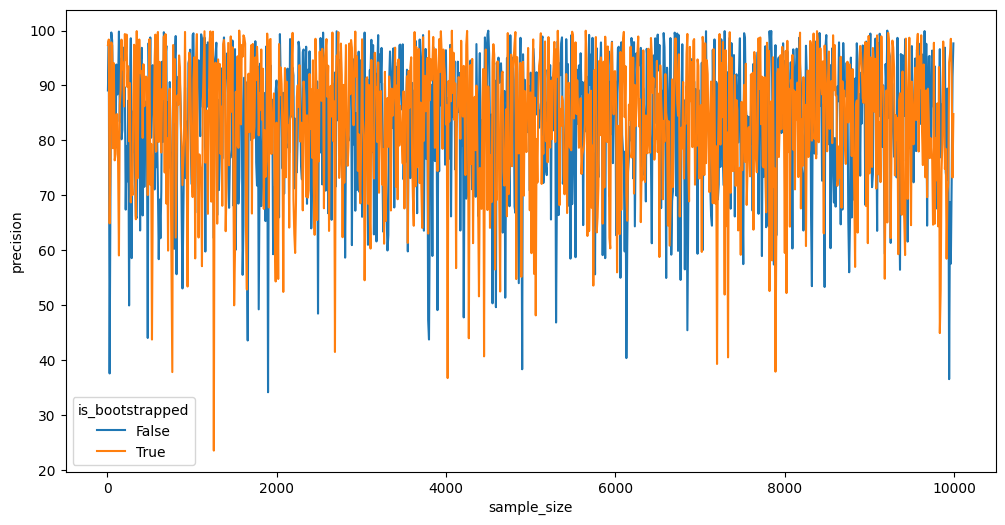

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='sample_size', y='precision', hue='is_bootstrapped')

<Axes: xlabel='sample_size', ylabel='recall'>

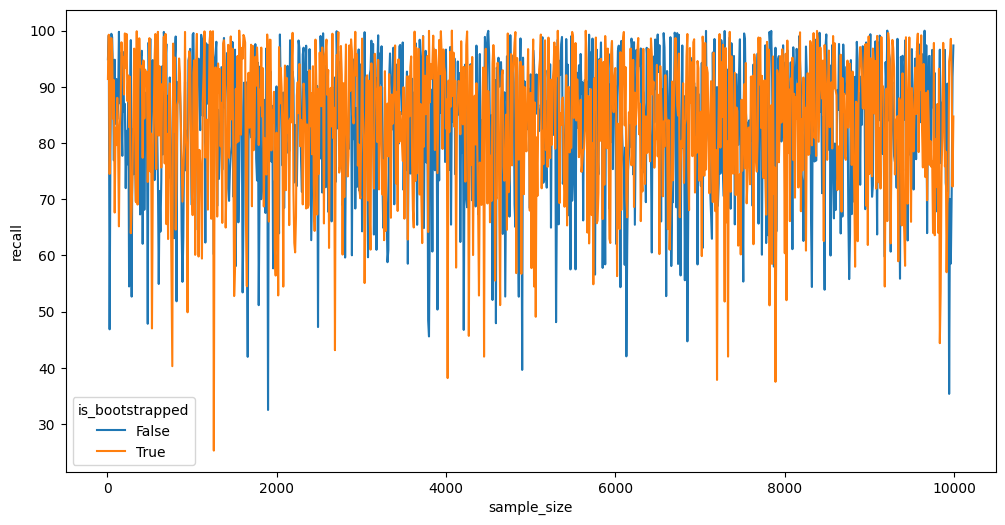

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='sample_size', y='recall', hue='is_bootstrapped')

In [8]:
df.groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})



,accuracy,recall,precision
is_bootstrapped,,,
False,98.941504,83.309979,83.294247
True,98.965407,83.222225,83.181900


In [9]:
df.groupby('is_bootstrapped').agg({'accuracy': 'std', 'recall': 'std', 'precision': 'std'})

,accuracy,recall,precision
is_bootstrapped,,,
False,1.394733,12.512110,12.516960
True,1.212217,12.415227,12.496897


In [18]:
df[df['sample_size'] > 2000].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,99.243643,83.532862,83.588126
True,99.224489,83.029384,83.012580


In [20]:
df[df['sample_size'] < 2000].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,97.726681,82.381144,82.076021
True,97.926394,84.003566,83.861588


In [24]:
df[df['sample_size'] < 300].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,95.474962,84.572238,83.668487
True,95.903503,86.419419,86.176301


In [31]:
df[df['sample_size'] < 100].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,93.452511,86.910442,84.316397
True,94.332322,87.384426,86.816652


In [32]:
df[(df['sample_size'] >= 500) & (df['sample_size'] <= 1000)].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,97.760673,81.458876,81.154641
True,97.805071,81.787941,81.742188


In [34]:
df[(df['sample_size'] >= 300) & (df['sample_size'] <= 500)].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,96.963143,81.438067,80.654175
True,97.880538,87.260815,87.160782


In [36]:
ab_df = iterate_testing_embbedded_ab_boostrapping(start_sample_size=10, end_sample_size=10000, increase_in_sample_size=10)

TPs are 295706, FPs are 6967, TNs are 668159, FNs are 29168
TPs are 301883, FPs are 5456, TNs are 670118, FNs are 22543
The sample size was 10
TPs are 301816, FPs are 14089, TNs are 652541, FNs are 31554
TPs are 309706, FPs are 10469, TNs are 656044, FNs are 23781
The sample size was 20
TPs are 264427, FPs are 36478, TNs are 626237, FNs are 72858
TPs are 270206, FPs are 34381, TNs are 627665, FNs are 67748
The sample size was 30
TPs are 156882, FPs are 62037, TNs are 742195, FNs are 38886
TPs are 155562, FPs are 64837, TNs are 738493, FNs are 41108
The sample size was 40
TPs are 178487, FPs are 11443, TNs are 790551, FNs are 19519
TPs are 179803, FPs are 10599, TNs are 791493, FNs are 18105
The sample size was 50
TPs are 176741, FPs are 5586, TNs are 808909, FNs are 8764
TPs are 179904, FPs are 3726, TNs are 810438, FNs are 5932
The sample size was 60
TPs are 144446, FPs are 11829, TNs are 824856, FNs are 18869
TPs are 146548, FPs are 10751, TNs are 825975, FNs are 16726
The sample siz

<Axes: xlabel='sample_size', ylabel='accuracy'>

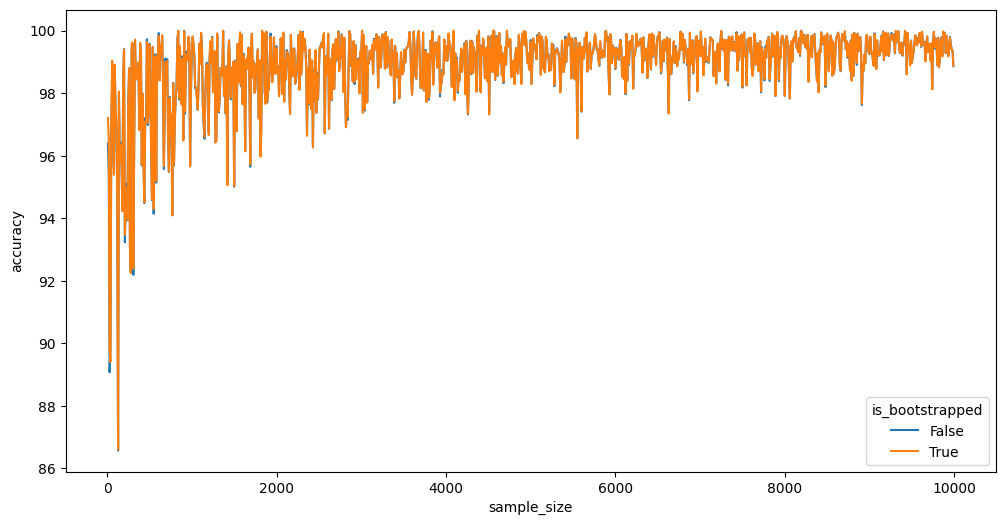

In [40]:
ab_df['accuracy'] = (ab_df['true_positives'] + ab_df['true_negatives']) / (ab_df['true_positives'] + ab_df['false_positives'] + ab_df['true_negatives'] + ab_df['false_negatives']) * 100
ab_df['recall'] = (ab_df['true_positives']) / (ab_df['true_positives'] + ab_df['false_negatives']) * 100
ab_df['precision'] = (ab_df['true_positives'] ) / (ab_df['true_positives'] + ab_df['false_positives']) * 100

plt.figure(figsize=(12, 6))
sns.lineplot(data=ab_df, x='sample_size', y='accuracy', hue='is_bootstrapped')

In [41]:
ab_df.groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,98.935032,82.854356,82.873577
True,98.939130,82.857615,82.888049


In [44]:
ab_df[(ab_df['sample_size'] >= 500) & (ab_df['sample_size'] <= 1000)].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,97.988902,83.472735,83.889761
True,98.000371,83.550200,83.904981


In [46]:
ab_df[ab_df['sample_size'] <= 500].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,96.384196,83.778609,84.127421
True,96.453772,83.949280,84.188035


In [49]:
ab_df[ab_df['sample_size'] <= 200].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,95.570065,85.518449,86.913036
True,95.746520,86.019043,87.125720


In [48]:
ab_df[ab_df['sample_size'] >= 2000].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,99.209998,82.833001,82.832573
True,99.209845,82.819763,82.844562
